## DS 4420 Project

### Kuan-Chun Chiu, Pual Champagne
### Prof. Gerber
### DS 4420
### 12/05/2025

#### Import all needed libraries

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import norm
import seaborn as sns
import pandas as pd
import numpy as np

#### Load the economic indicator and S&P 500 datasets

In [7]:
indicator_df = pd.read_csv("data/macro_indicators_data.csv")
indicator_df.rename(columns={"date": "Date"}, inplace=True)

print (f"Shape of the indicator df: {indicator_df.shape}")
indicator_df.head()

Shape of the indicator df: (5757, 10)


,Date,NFP_actual,NFP_forecast,NFP_surprise,core_PCE_actual,core_PCE_forecast,core_PCE_surprise,core_retail_sales_actual,core_retail_sales_forecast,core_retail_sales_surprise
0,2009-12-23,NaN,NaN,NaN,0.0,0.001,-0.001,NaN,NaN,NaN
1,2009-12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
stock_df = pd.read_csv("data/sp500_hist_returns.csv")
stock_df.rename(columns={"date": "Date"}, inplace=True)

print (f"Shape of the S&P 500 df: {stock_df.shape}")
stock_df.head()

Shape of the S&P 500 df: (4004, 8)


,Date,open,high,low,close,pct_change,volume,ln_return
0,2025-11-18,6641.19,6666.63,6574.32,6617.32,-0.0083,3206050763,-0.008289
1,2025-11-17,6713.61,6754.50,6638.90,6672.40,-0.0092,3074772162,-0.009206
2,2025-11-14,6672.14,6774.31,6646.87,6734.11,-0.0005,3079987673,-0.000512
3,2025-11-13,6826.47,6828.05,6724.72,6737.56,-0.0166,3327416477,-0.016695
4,2025-11-12,6867.77,6869.91,6829.62,6850.99,0.0006,2893216944,0.000640


#### Data preprocessing

In [9]:
kept_columns = ["Date", "ln_return"]
stock_df = stock_df[kept_columns]

surprise_columns = [column for column in indicator_df.columns if "surprise" in column]
kept_columns = ["Date"] + surprise_columns
indicator_df = indicator_df[kept_columns]
indicator_df[surprise_columns] = indicator_df[surprise_columns].fillna(0)

merged_df = indicator_df.merge(stock_df, on="Date", how="inner")
scaler = StandardScaler()
merged_df[surprise_columns] = scaler.fit_transform(merged_df[surprise_columns])

print (f"Shape of the merged df: {merged_df.shape}")
merged_df.head()

Shape of the merged df: (3965, 5)


,Date,NFP_surprise,core_PCE_surprise,core_retail_sales_surprise,ln_return
0,2009-12-23,-0.020026,-6.219787,-0.000426,0.002296
1,2009-12-24,-0.020026,0.055393,-0.000426,0.005242
2,2009-12-28,-0.020026,0.055393,-0.000426,0.001153
3,2009-12-29,-0.020026,0.055393,-0.000426,-0.001402
4,2009-12-30,-0.020026,0.055393,-0.000426,0.000195


#### Create X matrix and y (target) array

In [10]:
y = merged_df["ln_return"].to_numpy()
X = merged_df[surprise_columns].to_numpy()
bias_column = np.ones(len(X), dtype="float").reshape(-1, 1)
X = np.concatenate((bias_column, X), axis=1)

print (f"X matrix shape: {X.shape}")
print (f"y array shape: {y.shape}\n")
print (f"First 5 rows of X matrix: \n{X[:5]}\n")
print (f"First 5 values of y array: \n{y[:5]}")

X matrix shape: (3965, 4)
y array shape: (3965,)

First 5 rows of X matrix: 
[[ 1.00000000e+00 -2.00257263e-02 -6.21978721e+00 -4.25579639e-04]
 [ 1.00000000e+00 -2.00257263e-02  5.53925070e-02 -4.25579639e-04]
 [ 1.00000000e+00 -2.00257263e-02  5.53925070e-02 -4.25579639e-04]
 [ 1.00000000e+00 -2.00257263e-02  5.53925070e-02 -4.25579639e-04]
 [ 1.00000000e+00 -2.00257263e-02  5.53925070e-02 -4.25579639e-04]]

First 5 values of y array: 
[ 0.00229607  0.00524239  0.00115337 -0.00140197  0.00019533]


#### Create training and testing subset

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

print (f"Shape of X_train matrix: {X_train.shape}")
print (f"Shape of X_test matrix: {X_test.shape}")
print (f"Shape of y_train array: {y_train.shape}")
print (f"Shape of y_test array: {y_test.shape}")

Shape of X_train matrix: (2973, 4)
Shape of X_test matrix: (992, 4)
Shape of y_train array: (2973,)
Shape of y_test array: (992,)


#### Define prior distribution

In [14]:
alpha = 0.01
feature_num = X_train.shape[1]

identity = np.eye(feature_num)
identity[0, 0] = 0
prior_cov = (1/alpha) * identity
prior_cov[0, 0] = np.inf
prior_mean = np.zeros(feature_num).reshape(-1, 1)

print (f"Prior distribution mean: \n{prior_mean}\n")
print (f"Prior distribution covariance matrix: \n{prior_cov}")

Prior distribution mean: 
[[0.]
 [0.]
 [0.]
 [0.]]

Prior distribution covariance matrix: 
[[ inf   0.   0.   0.]
 [  0. 100.   0.   0.]
 [  0.   0. 100.   0.]
 [  0.   0.   0. 100.]]


#### Define posterior distribution

In [15]:
data_std = np.std(y_train)
prior_prec = np.eye(feature_num) * alpha
prior_prec[0, 0] = 0

cov_part_1 = np.matmul(X_train.T, X_train)
cov_part_2 = ((1/data_std**2)) * cov_part_1
cov_part_3 = prior_prec + cov_part_2
posterior_cov = np.linalg.inv(cov_part_3)

mean_part_1 = np.matmul(X_train.T, y_train).reshape(-1, 1)
mean_part_2 = (1/data_std**2) * mean_part_1
mean_part_3 = np.matmul(prior_prec, prior_mean)
mean_part_4 = mean_part_3 + mean_part_2
posterior_mean = np.matmul(posterior_cov, mean_part_4)


print (f"Posterior distribution mean: \n{posterior_mean}\n")
print (f"Posterior distribution covariance matrix: \n{posterior_cov}")

Posterior distribution mean: 
[[4.40400257e-04]
 [1.08421774e-03]
 [1.67785031e-05]
 [2.02714726e-04]]

Posterior distribution covariance matrix: 
[[ 4.18765220e-08  6.69539883e-09 -3.81850092e-10 -1.07935730e-09]
 [ 6.69539883e-09  5.20463736e-07 -3.40051130e-11  9.84732013e-11]
 [-3.81850092e-10 -3.40051130e-11  4.27048976e-08 -5.23997550e-11]
 [-1.07935730e-09  9.84732013e-11 -5.23997550e-11  5.25440991e-08]]


### Evaluating each macroeconomic indicator's impact on S&P return

#### Extract the posterior mean of indicator coefficients

In [16]:
coef_names = ["Intercept"] + surprise_columns
posterior_means = posterior_mean.flatten()

for idx, name in enumerate(coef_names):
    if name == "Intercept":
        continue
    print (f"On average, {name} moves the S&P return by: {posterior_means[idx]:.5f}")

On average, NFP_surprise moves the S&P return by: 0.00108
On average, core_PCE_surprise moves the S&P return by: 0.00002
On average, core_retail_sales_surprise moves the S&P return by: 0.00020


#### Compute the 95% interval for each indicator coefficient

In [17]:
posterior_std = np.sqrt(np.diag(posterior_cov))
lower_interval = posterior_means - posterior_std * 1.96
upper_interval = posterior_means + posterior_std * 1.96

for idx, name in enumerate(coef_names):
    print (f"{name} coefficient 95% interval: ({lower_interval[idx]:.5f}, {upper_interval[idx]:.5f})")

Intercept coefficient 95% interval: (0.00004, 0.00084)
NFP_surprise coefficient 95% interval: (-0.00033, 0.00250)
core_PCE_surprise coefficient 95% interval: (-0.00039, 0.00042)
core_retail_sales_surprise coefficient 95% interval: (-0.00025, 0.00065)


#### Compute the probability that each indicator coefficient is positive

In [18]:
coef_positive_probs = 1 - norm.cdf(0, loc=posterior_means, scale=posterior_std)

for idx, name in enumerate(coef_names):
    if name == "Intercept":
        continue
    print (f"Probability that {name} coefficient is positive: {coef_positive_probs[idx]:.4f}")

Probability that NFP_surprise coefficient is positive: 0.9336
Probability that core_PCE_surprise coefficient is positive: 0.5324
Probability that core_retail_sales_surprise coefficient is positive: 0.8117


#### Computing the effect size of 1 standard deviation for each indicator

In [19]:
for idx, name in enumerate(coef_names):
    if name == "Intercept":
        continue
    print (f"The effect of {name} moving 1 standard deviation on S&P return: {posterior_means[idx]:.5f}")

The effect of NFP_surprise moving 1 standard deviation on S&P return: 0.00108
The effect of core_PCE_surprise moving 1 standard deviation on S&P return: 0.00002
The effect of core_retail_sales_surprise moving 1 standard deviation on S&P return: 0.00020


#### Scenario analysis: How does the posterior distribution look like for each indicator when they are up by 2 standard deviation

##### Scenario 1: NFP up by 2 standard deviation, the rest are hold constant

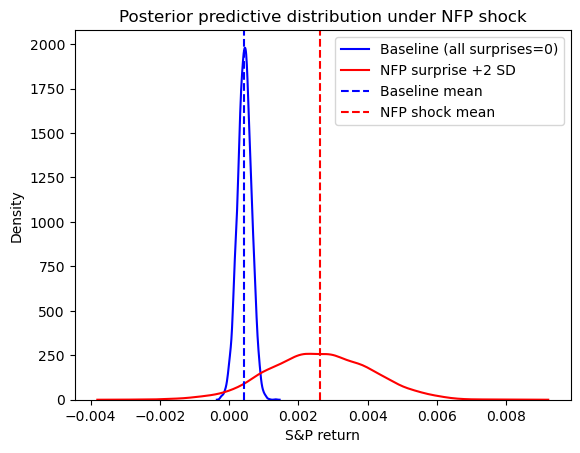

In [52]:
normal_surprise = np.array([1, 0, 0, 0]).reshape(-1, 1)
scen1_surprise = np.array([1, 2, 0, 0]).reshape(-1, 1)

sample_size = 5000
posterior_samples = np.random.multivariate_normal(
    mean = posterior_means,
    cov = posterior_cov,
    size = sample_size
)

normal_return = np.matmul(posterior_samples, normal_surprise).flatten()
scen1_return = np.matmul(posterior_samples, scen1_surprise).flatten()

sns.kdeplot(data=normal_return, color="blue", label="Baseline (all surprises=0)")
sns.kdeplot(data=scen1_return, color="red", label="NFP surprise +2 SD")
plt.axvline(normal_return.mean(), color="blue", linestyle="--", label="Baseline mean")
plt.axvline(scen1_return.mean(), color="red", linestyle="--", label="NFP shock mean")
plt.title("Posterior predictive distribution under NFP shock")
plt.xlabel("S&P return")
plt.ylabel("Density")
plt.legend()
plt.show()

##### Scenario 2: PCE up by 2 standard deviation, the rest are hold constant

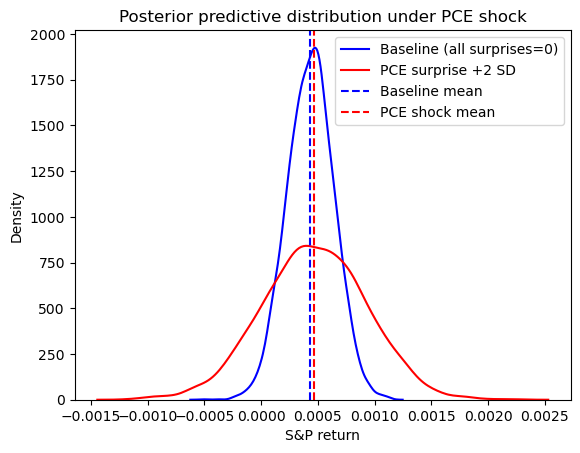

In [53]:
scen2_surprise = np.array([1, 0, 2, 0]).reshape(-1, 1)

sample_size = 5000
posterior_samples = np.random.multivariate_normal(
    mean = posterior_means,
    cov = posterior_cov,
    size = sample_size
)

normal_return = np.matmul(posterior_samples, normal_surprise).flatten()
scen2_return = np.matmul(posterior_samples, scen2_surprise).flatten()

sns.kdeplot(data=normal_return, color="blue", label="Baseline (all surprises=0)")
sns.kdeplot(data=scen2_return, color="red", label="PCE surprise +2 SD")
plt.axvline(normal_return.mean(), color="blue", linestyle="--", label="Baseline mean")
plt.axvline(scen2_return.mean(), color="red", linestyle="--", label="PCE shock mean")
plt.title("Posterior predictive distribution under PCE shock")
plt.xlabel("S&P return")
plt.ylabel("Density")
plt.legend()
plt.show()

##### Scenario 3: Retail sales up by 2 standard deviation, the rest are hold constant

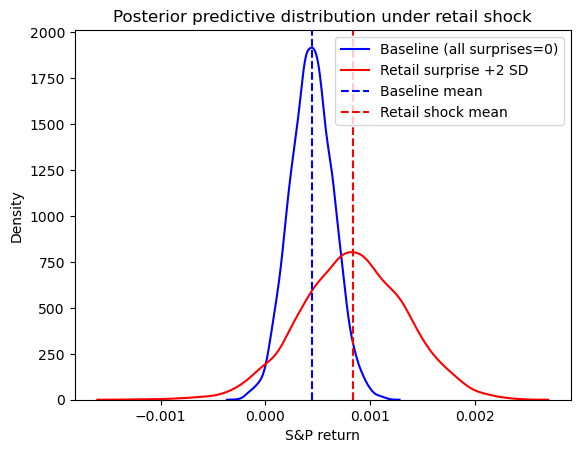

In [54]:
scen3_surprise = np.array([1, 0, 0, 2]).reshape(-1, 1)

sample_size = 5000
posterior_samples = np.random.multivariate_normal(
    mean = posterior_means,
    cov = posterior_cov,
    size = sample_size
)

normal_return = np.matmul(posterior_samples, normal_surprise).flatten()
scen3_return = np.matmul(posterior_samples, scen3_surprise).flatten()

sns.kdeplot(data=normal_return, color="blue", label="Baseline (all surprises=0)")
sns.kdeplot(data=scen3_return, color="red", label="Retail surprise +2 SD")
plt.axvline(normal_return.mean(), color="blue", linestyle="--", label="Baseline mean")
plt.axvline(scen3_return.mean(), color="red", linestyle="--", label="Retail shock mean")
plt.title("Posterior predictive distribution under retail shock")
plt.xlabel("S&P return")
plt.ylabel("Density")
plt.legend()
plt.show()

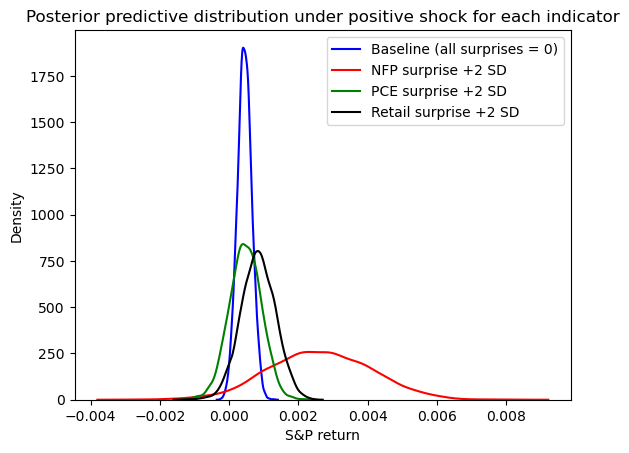

In [57]:
sns.kdeplot(data=normal_return, color="blue", label="Baseline (all surprises = 0)")
sns.kdeplot(data=scen1_return, color="red", label="NFP surprise +2 SD")
sns.kdeplot(data=scen2_return, color="green", label="PCE surprise +2 SD")
sns.kdeplot(data=scen3_return, color="black", label="Retail surprise +2 SD")

plt.title("Posterior predictive distribution under positive shock for each indicator")
plt.xlabel("S&P return")
plt.ylabel("Density")
plt.legend()
plt.show()

#### Scenario analysis: How does the posterior distribution look like for each indicator when they are down by 2 standard deviation

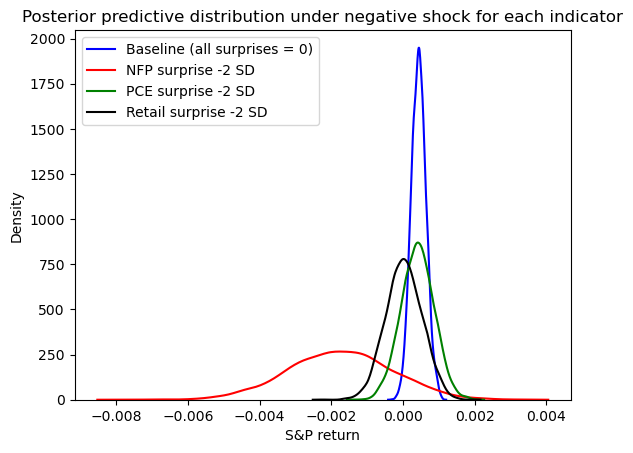

In [58]:
scen4_surprise = np.array([1, -2, 0, 0]).reshape(-1, 1)
scen5_surprise = np.array([1, 0, -2, 0]).reshape(-1, 1)
scen6_surprise = np.array([1, 0, 0, -2]).reshape(-1, 1)

sample_size = 5000
posterior_samples = np.random.multivariate_normal(
    mean = posterior_means,
    cov = posterior_cov,
    size = sample_size
)

normal_return = np.matmul(posterior_samples, normal_surprise).flatten()
scen4_return = np.matmul(posterior_samples, scen4_surprise).flatten()
scen5_return = np.matmul(posterior_samples, scen5_surprise).flatten()
scen6_return = np.matmul(posterior_samples, scen6_surprise).flatten()

sns.kdeplot(data=normal_return, color="blue", label="Baseline (all surprises = 0)")
sns.kdeplot(data=scen4_return, color="red", label="NFP surprise -2 SD")
sns.kdeplot(data=scen5_return, color="green", label="PCE surprise -2 SD")
sns.kdeplot(data=scen6_return, color="black", label="Retail surprise -2 SD")

plt.title("Posterior predictive distribution under negative shock for each indicator")
plt.xlabel("S&P return")
plt.ylabel("Density")
plt.legend()
plt.show()

In [62]:
normal_return.mean().item(), scen1_return.mean().item(), scen2_return.mean().item(), scen3_return.mean().item()

(0.00043870881024672074,
 0.0026235298019432864,
 0.00046664404819662486,
 0.0008339328908704744)

In [63]:
scen4_return.mean().item(), scen5_return.mean().item(), scen6_return.mean().item()

(-0.0017441956789844867, 0.0004081158284042849, 2.988774044182694e-05)